# Fog and Storm Detection - Climate Risk and Disaster Management Project
This project explores a dataset related to fog and storm events, focusing on climate risk and disaster management.

In [1]:
#here firdst we will setup the project:
import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
sns.set_theme(context="notebook", style="whitegrid")

print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)

Versions -> pandas: 2.3.2 | numpy: 2.3.3


In [2]:
#Now We will load the data here

CSV_PATH = "fog_storm_dataset.csv"
df_raw = pd.read_csv(
    CSV_PATH,
    parse_dates=["Date"],
    dayfirst=False,            
    infer_datetime_format=True
)

print("Loaded shape:", df_raw.shape)
df_raw.head()

Loaded shape: (10, 7)


,Date,Temperature(C),Humidity(%),WindSpeed(km/h),Visibility(km),Fog,Storm
0,2025-01-01,12,85,5,2.000,1,0
1,2025-01-02,14,90,7,3.000,0,1
2,2025-01-03,9,92,6,1.000,1,0
3,2025-01-04,7,95,4,0.500,1,1
4,2025-01-05,6,80,3,0.800,1,0


In [3]:
#Now here I will cleann the dataset
df = df_raw.copy()

#doing the Standardization
rename_map = {
    "Date": "date",
    "Temperature(C)": "temperature_c",
    "Humidity(%)": "humidity_pct",
    "WindSpeed(km/h)": "wind_kmh",
    "Visibility(km)": "visibility_km",
    "Fog": "fog",
    "Storm": "storm"
}
df.rename(columns=rename_map, inplace=True)

numeric_cols = ["temperature_c", "humidity_pct", "wind_kmh", "visibility_km"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in ["fog", "storm"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    df[c] = df[c].astype("category")

#basic datetime check
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

df.head()


,date,temperature_c,humidity_pct,wind_kmh,visibility_km,fog,storm
0,2025-01-01,12,85,5,2.000,1,0
1,2025-01-02,14,90,7,3.000,0,1
2,2025-01-03,9,92,6,1.000,1,0
3,2025-01-04,7,95,4,0.500,1,1
4,2025-01-05,6,80,3,0.800,1,0


In [4]:
#see the structure now,
print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())
display(df.tail(3))


Shape: (10, 7)

Dtypes:
date             datetime64[ns]
temperature_c             int64
humidity_pct              int64
wind_kmh                  int64
visibility_km           float64
fog                    category
storm                  category
dtype: object

Missing values per column:
date             0
temperature_c    0
humidity_pct     0
wind_kmh         0
visibility_km    0
fog              0
storm            0
dtype: int64

Duplicate rows: 0


,date,temperature_c,humidity_pct,wind_kmh,visibility_km,fog,storm
7,2025-01-08,8,93,5,1.500,1,0
8,2025-01-09,10,91,6,2.200,1,0
9,2025-01-10,11,87,8,3.500,0,1


In [5]:
#remove trhe duplicates here,
df_nodup = df.drop_duplicates().copy()
print("Removed duplicates:", len(df) - len(df_nodup))
df = df_nodup


Removed duplicates: 0


In [6]:
#date amd time feature
df["year"]       = df["date"].dt.year
df["month"]      = df["date"].dt.month
df["day"]        = df["date"].dt.day
df["dayofweek"]  = df["date"].dt.dayofweek  # Monday=0
df["week"]       = df["date"].dt.isocalendar().week.astype(int)
df["dayofyear"]  = df["date"].dt.dayofyear

df.head(3)


,date,temperature_c,humidity_pct,wind_kmh,visibility_km,fog,storm,year,month,day,dayofweek,week,dayofyear
0,2025-01-01,12,85,5,2.000,1,0,2025,1,1,2,1,1
1,2025-01-02,14,90,7,3.000,0,1,2025,1,2,3,1,2
2,2025-01-03,9,92,6,1.000,1,0,2025,1,3,4,1,3


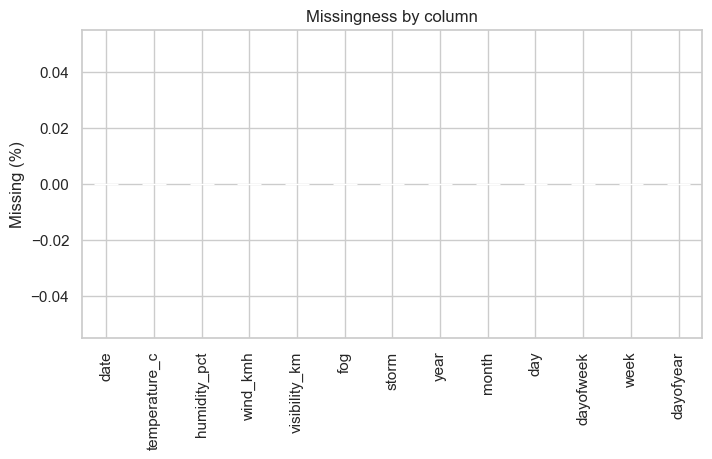

Any NA left in df_clean? False


In [7]:
#now we will see hte meaningness visualization,
ax = (df.isna().mean()*100).sort_values(ascending=False).plot.bar(figsize=(8,4))
ax.set_ylabel("Missing (%)"); ax.set_title("Missingness by column"); plt.show()

df_clean = df.copy()
df_clean[numeric_cols] = df_clean[numeric_cols].interpolate(limit_direction="both")
print("Any NA left in df_clean?", df_clean.isna().any().any())

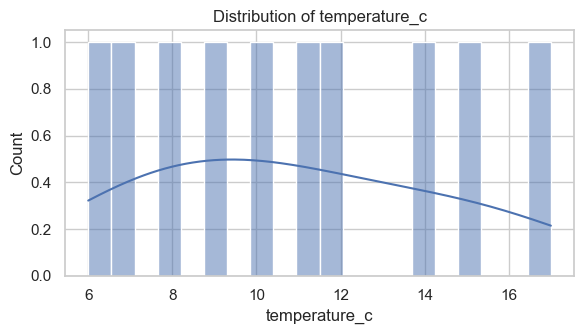

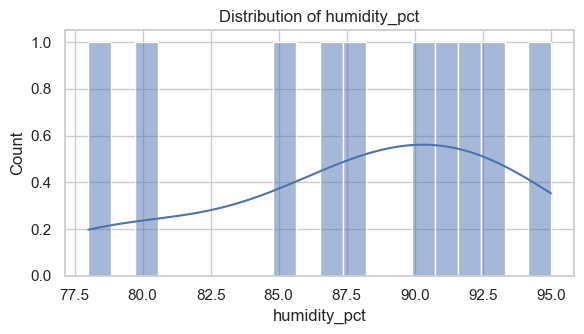

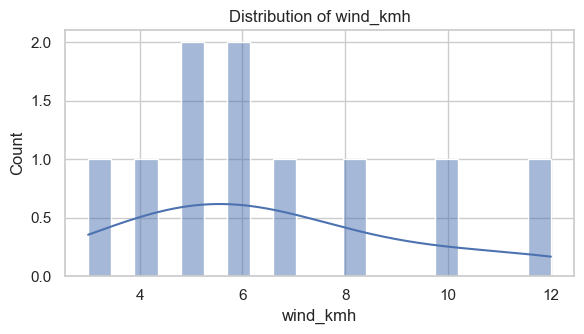

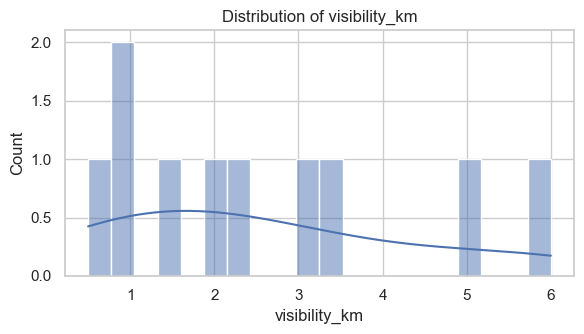

In [8]:
#histogram + KDE here
for c in numeric_cols:
    plt.figure(figsize=(6,3.5))
    sns.histplot(data=df, x=c, bins=20, kde=True)
    plt.title(f"Distribution of {c}")
    plt.tight_layout()
    plt.show()


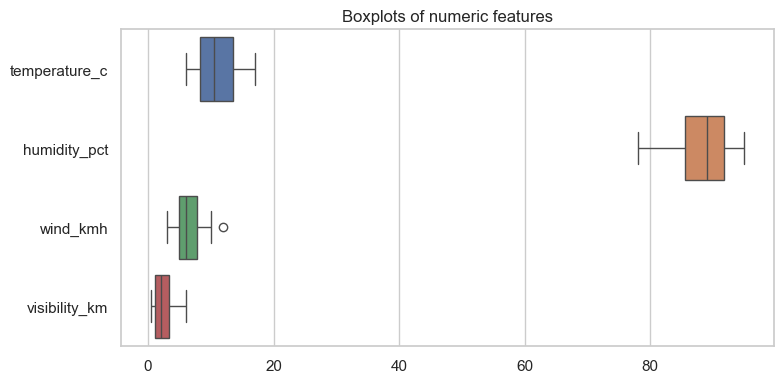

In [9]:
#box plot - ye detect kr lega outlier ko fastly,
plt.figure(figsize=(8,4))
sns.boxplot(data=df[numeric_cols], orient="h")
plt.title("Boxplots of numeric features")
plt.tight_layout()
plt.show()


In [10]:
#IQR outlier flags
def iqr_outlier_flags(data, cols):
    out = {}
    for c in cols:
        q1, q3 = data[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        out[c] = {
            "low_thresh": lo, "high_thresh": hi,
            "low_outliers": int((data[c] < lo).sum()),
            "high_outliers": int((data[c] > hi).sum())
        }
    return pd.DataFrame(out).T

iqr_summary = iqr_outlier_flags(df, numeric_cols)
iqr_summary


,low_thresh,high_thresh,low_outliers,high_outliers
temperature_c,0.375,21.375,0.000,0.000
humidity_pct,76.125,101.125,0.000,0.000
wind_kmh,0.875,11.875,0.000,1.000
visibility_km,-2.250,6.750,0.000,0.000


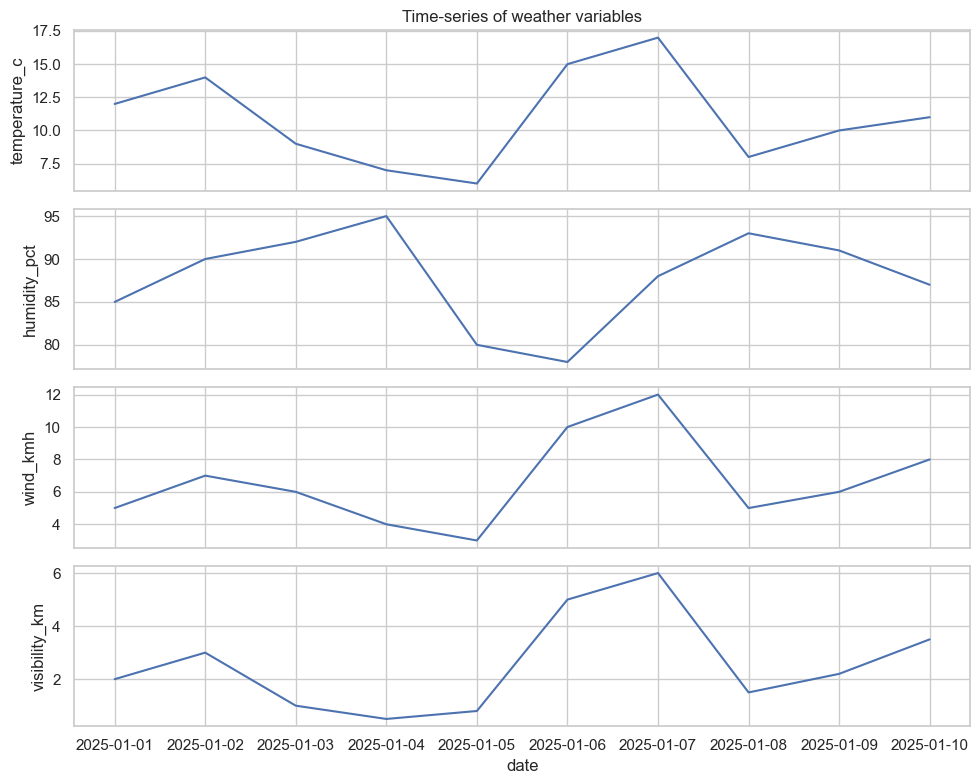

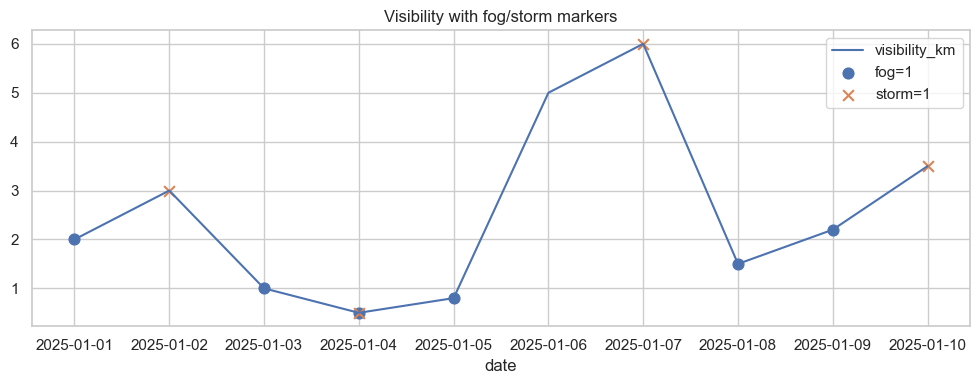

In [11]:
#time series view
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 8), sharex=True)
for ax, c in zip(axes, numeric_cols):
    ax.plot(df["date"], df[c])
    ax.set_ylabel(c)
axes[0].set_title("Time-series of weather variables")
axes[-1].set_xlabel("date")
plt.tight_layout()
plt.show()

#mark fog & storm events
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["visibility_km"], label="visibility_km")
fog_dates   = df.loc[df["fog"]==1, "date"]
storm_dates = df.loc[df["storm"]==1, "date"]
plt.scatter(fog_dates, df.loc[df["fog"]==1, "visibility_km"], marker="o", s=60, label="fog=1")
plt.scatter(storm_dates, df.loc[df["storm"]==1, "visibility_km"], marker="x", s=60, label="storm=1")
plt.legend(); plt.title("Visibility with fog/storm markers"); plt.xlabel("date")
plt.tight_layout(); plt.show()


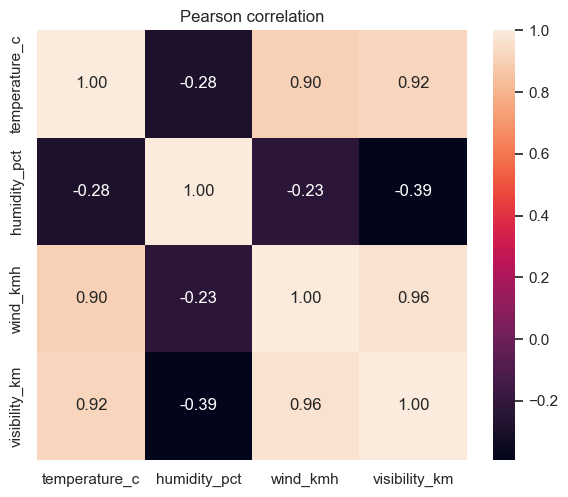

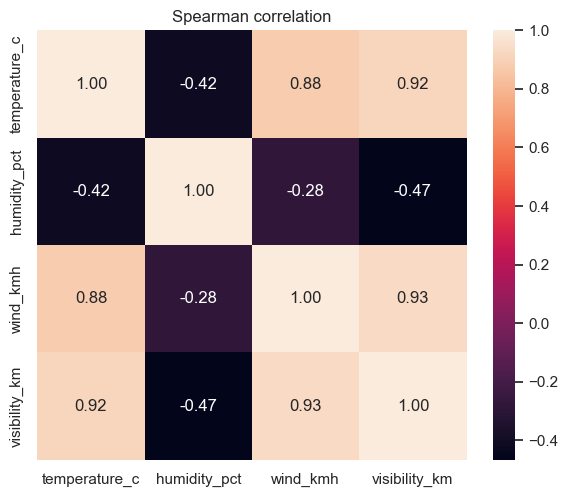

(               temperature_c  humidity_pct  wind_kmh  visibility_km
 temperature_c          1.000        -0.284     0.901          0.923
 humidity_pct          -0.284         1.000    -0.228         -0.391
 wind_kmh               0.901        -0.228     1.000          0.964
 visibility_km          0.923        -0.391     0.964          1.000,
                temperature_c  humidity_pct  wind_kmh  visibility_km
 temperature_c          1.000        -0.418     0.878          0.915
 humidity_pct          -0.418         1.000    -0.280         -0.467
 wind_kmh               0.878        -0.280     1.000          0.933
 visibility_km          0.915        -0.467     0.933          1.000)

In [12]:
#correlation analysis
def corr_heatmap(frame, cols, method="pearson", title=None):
    corr = frame[cols].corr(method=method)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True)
    plt.title(title or f"{method.title()} correlation")
    plt.tight_layout(); plt.show()
    return corr

corr_pearson = corr_heatmap(df, numeric_cols, method="pearson", title="Pearson correlation")
corr_spearman = corr_heatmap(df, numeric_cols, method="spearman", title="Spearman correlation")

corr_pearson, corr_spearman


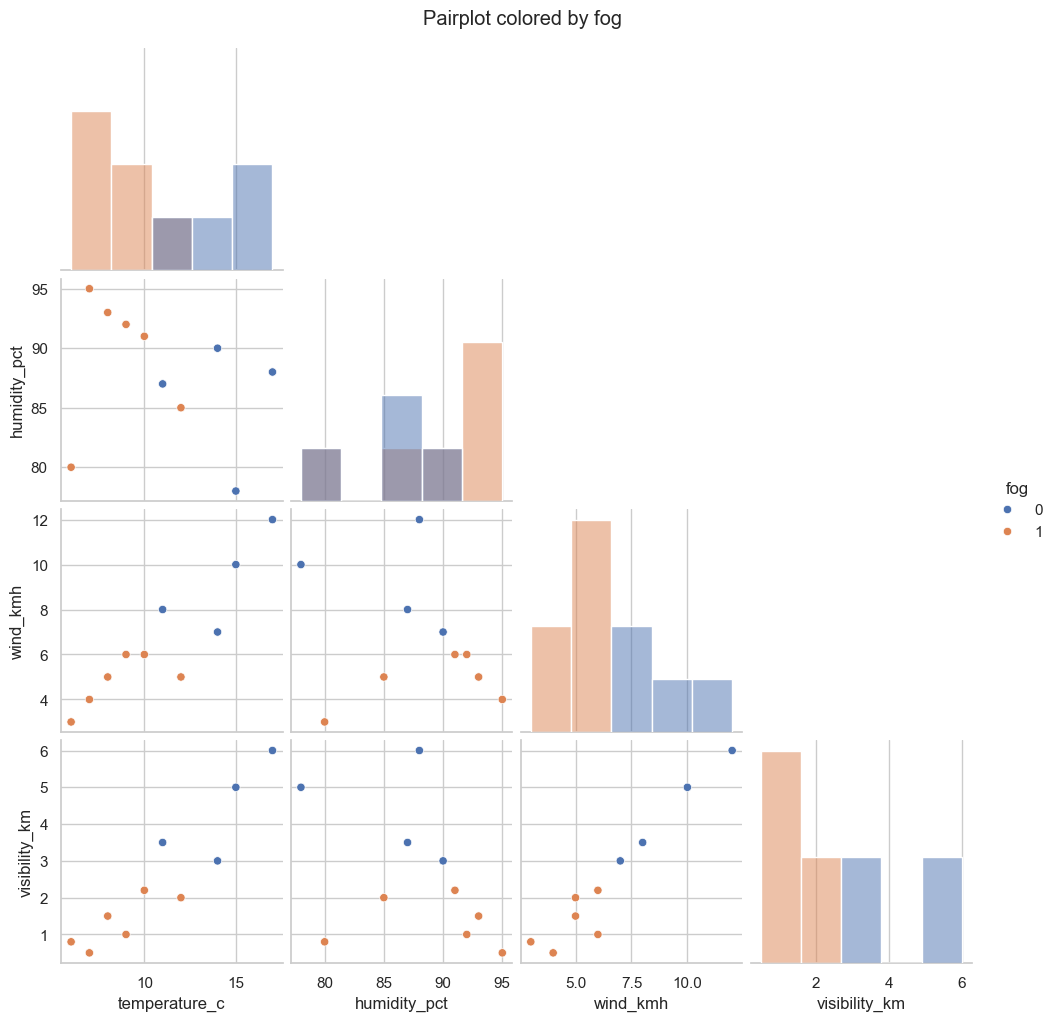

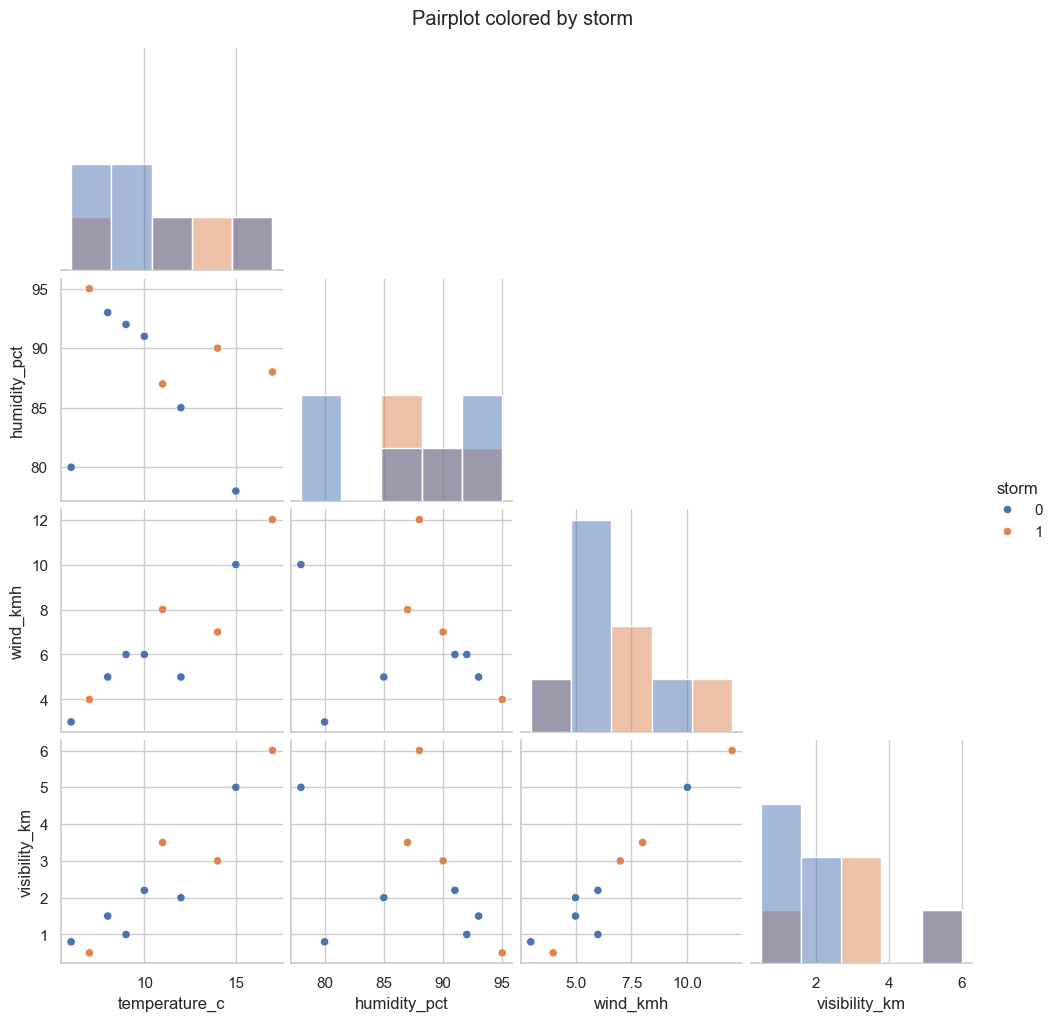

In [13]:
#pairwise relationship
sample = df.sample(min(len(df), 1000), random_state=42)
sns.pairplot(sample, vars=numeric_cols, hue="fog", corner=True, diag_kind="hist")
plt.suptitle("Pairplot colored by fog", y=1.02)
plt.show()

sns.pairplot(sample, vars=numeric_cols, hue="storm", corner=True, diag_kind="hist")
plt.suptitle("Pairplot colored by storm", y=1.02)
plt.show()


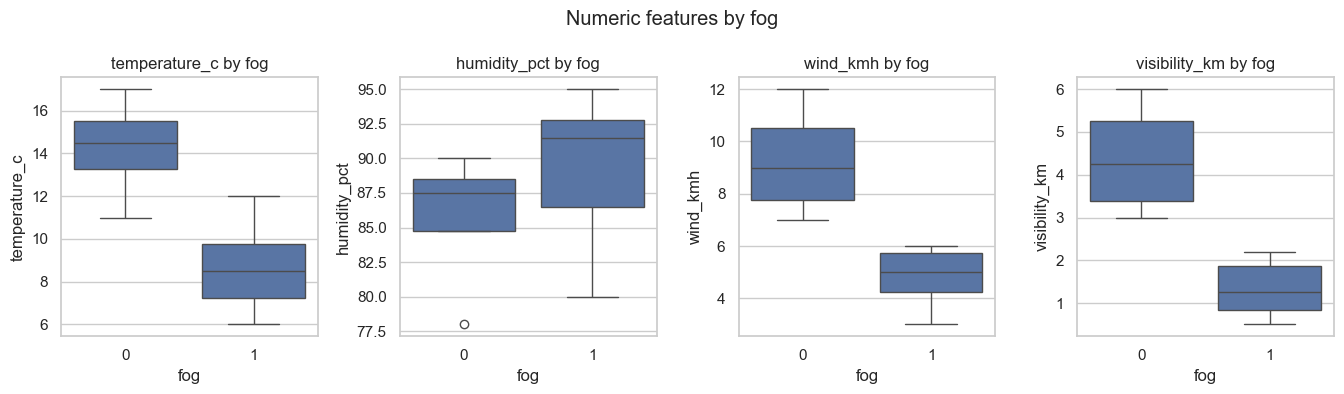

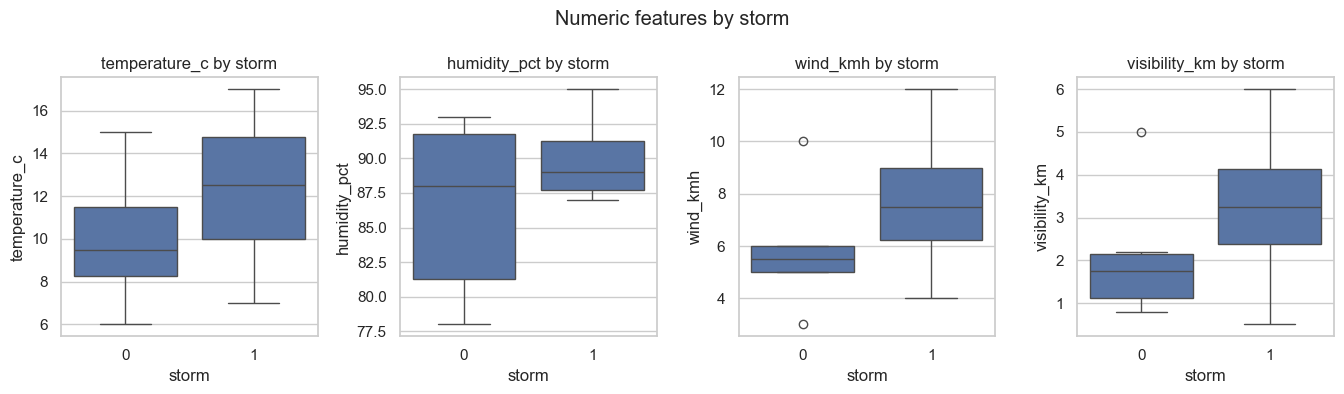

In [14]:
#ab target relationship, numeric vs fog/storm
for target in ["fog", "storm"]:
    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(1.9*len(numeric_cols)+6, 4), sharey=False)
    if len(numeric_cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, numeric_cols):
        sns.boxplot(data=df, x=target, y=c, ax=ax)
        ax.set_title(f"{c} by {target}")
    plt.suptitle(f"Numeric features by {target}")
    plt.tight_layout()
    plt.show()


Counts:


storm,0,1,All
fog,,,
0,1,3,4
1,5,1,6
All,6,4,10



Row-wise %:


storm,0,1
fog,,
0,0.250,0.750
1,0.833,0.167


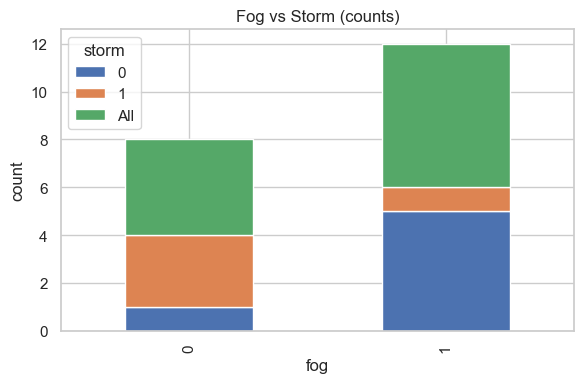

In [15]:
#fog vs storm cross tab
ct = pd.crosstab(df["fog"], df["storm"], margins=True)
ct_pct = pd.crosstab(df["fog"], df["storm"], normalize="index").round(3)

print("Counts:")
display(ct)
print("\nRow-wise %:")
display(ct_pct)

#stacked bar
ax = ct.drop("All").plot(kind="bar", stacked=True, figsize=(6,4))
ax.set_title("Fog vs Storm (counts)")
ax.set_xlabel("fog")
ax.set_ylabel("count")
plt.tight_layout(); plt.show()


In [16]:
#save itt
OUT_PATH = "fog_storm_dataset_clean.csv"
df.to_csv(OUT_PATH, index=False)
print("Saved:", os.path.abspath(OUT_PATH))


Saved: c:\Users\dell\Fog_and_Storm_Detection\fog_storm_dataset_clean.csv


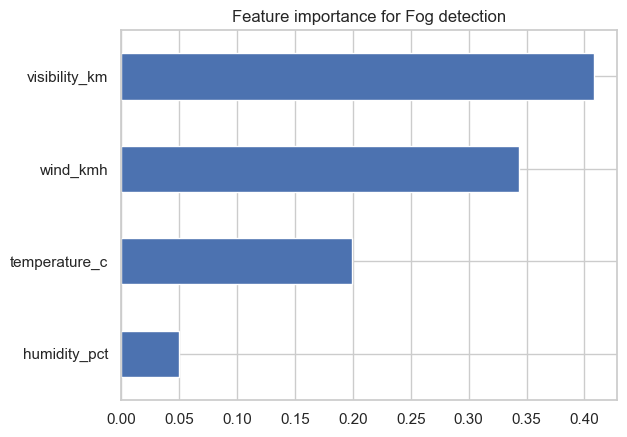

Fog Detection Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



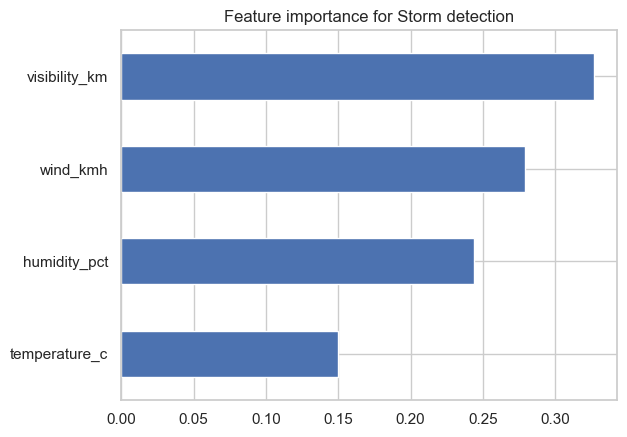

Storm Detection Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



In [17]:
# ==============================
# Feature Selection & Importance
# ==============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Using only numeric weather features
numeric_cols = ["temperature_c", "humidity_pct", "wind_kmh", "visibility_km"]
X = df[numeric_cols]

# ----- Fog -----
y_fog = df["fog"]
X_train, X_test, y_train, y_test = train_test_split(X, y_fog, test_size=0.3, random_state=42)

model_fog = RandomForestClassifier(random_state=42)
model_fog.fit(X_train, y_train)

importances_fog = pd.Series(model_fog.feature_importances_, index=numeric_cols)
importances_fog.sort_values().plot.barh()
plt.title("Feature importance for Fog detection")
plt.show()

print("Fog Detection Report:\n", classification_report(y_test, model_fog.predict(X_test)))

# ----- Storm -----
y_storm = df["storm"]
X_train, X_test, y_train, y_test = train_test_split(X, y_storm, test_size=0.3, random_state=42)

model_storm = RandomForestClassifier(random_state=42)
model_storm.fit(X_train, y_train)

importances_storm = pd.Series(model_storm.feature_importances_, index=numeric_cols)
importances_storm.sort_values().plot.barh()
plt.title("Feature importance for Storm detection")
plt.show()

print("Storm Detection Report:\n", classification_report(y_test, model_storm.predict(X_test)))
